In [1]:
import numpy as np
import openpyxl
from pandas import DataFrame as DF
from pandas import read_csv, merge, read_excel
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt


In [2]:
def make_float(data):
    new_data = []
    for obj in data:
        try:
            obj = float(obj)
        except:
            obj = np.nan
        new_data.append(obj)
    return new_data

In [3]:
ipath = 'results/'

In [4]:
ls results/

Reconciliation 1.xlsx     loan_summary.csv          payment.csv
connectedness.csv         loan_summary.xlsx         person.csv
current_status.csv        new_loan.csv              prev_loan.csv
current_status.xlsx       new_loan_tbl.xlsx         ttl_ld_pf_amt.png
disbursed.csv             new_loan_updated.xlsx*    ttl_pf_amt.png
disbursed.xlsx            new_payment.csv           ttl_usd_pf_amt.png
iron_coin_v01.xlsx        new_payment.xlsx          weekly_loan_summary.csv
loan.csv                  new_payment02.csv         weekly_loan_summary.xlsx
loan_plan.csv             new_payment_updated.xlsx


In [5]:
ifile = ipath + 'new_loan.csv'
loan = read_csv(ifile)

ifile = ipath + 'new_payment_updated.xlsx'
pmt = read_excel(ifile)

In [6]:
pmt = pmt.replace(['2017-11-31'], '2017-11-30')

In [7]:
loan.columns

Index(['id', 'loan_id', 'loan_type', 'amt_requested', 'loan_amt_usd',
       'loan_amt_ld', 'rate', 'interest_ld', 'interest_usd', 'duration_month',
       'status', 'take_out_dt', 'loan_plus_intr_ld', 'loan_plus_intr_usd'],
      dtype='object')

In [8]:
float_cols = ['loan_amt_usd', 'loan_amt_ld', 'rate', 'interest_ld', 'interest_usd',  
              'loan_plus_intr_ld', 'loan_plus_intr_usd']
for col in float_cols:
    loan[col] = make_float(loan[col])

In [9]:
loan.dtypes

id                      int64
loan_id                object
loan_type              object
amt_requested          object
loan_amt_usd          float64
loan_amt_ld           float64
rate                  float64
interest_ld           float64
interest_usd          float64
duration_month        float64
status                 object
take_out_dt            object
loan_plus_intr_ld     float64
loan_plus_intr_usd    float64
dtype: object

In [10]:
pmt.columns

Index(['id', 'loan_id', 'loan_plus_intr_usd', 'loan_plus_intr_ld',
       'payment_dt', 'payment_amt_usd', 'payment_amt_ld', 'loan_bal_usd',
       'loan_bal_ld', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

In [11]:
float_cols = ['loan_plus_intr_usd', 'loan_plus_intr_ld', 'payment_amt_usd', 'payment_amt_ld', 
              'loan_bal_usd','loan_bal_ld']
for col in float_cols:
    pmt[col] = make_float(pmt[col])

In [12]:
pmt.dtypes

id                      int64
loan_id                object
loan_plus_intr_usd    float64
loan_plus_intr_ld     float64
payment_dt             object
payment_amt_usd       float64
payment_amt_ld        float64
loan_bal_usd          float64
loan_bal_ld           float64
Unnamed: 9             object
Unnamed: 10            object
dtype: object

In [25]:
def get_monthly_data(data, year, month, date_col_name, date_range=None,  loan_ids=None):
    year = int(year)
    month = int(month)
    if date_col_name == 'take_out_dt':
        status_cond = np.array([str(val).startswith('appr') for val in data.status])
        if date_range is None:        
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                                 (dt.datetime.strptime(val, '%Y-%m-%d').month == month) if isinstance(val, str) and len(val) >= 6 else False for val 
                       in data[date_col_name]])

        elif date_range.lower() == 'ytd':
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                                 (dt.datetime.strptime(val, '%Y-%m-%d').month <= month) if isinstance(val, str) and len(val) >= 6 else False for val 
                       in data[date_col_name]])
        elif date_range.lower() == 'total':
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year <= year) if isinstance(val, str) and len(val) >= 6 else False for val 
                       in data[date_col_name]])
        mthly_data = DF(data.loc[(dt_cond) & (status_cond)])
    elif date_col_name == 'payment_dt':
        dt_len = 6 #min length of date
        if date_range is None:
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                                 (dt.datetime.strptime(val, '%Y-%m-%d').month <= month) if isinstance(val, str) and len(val) >= dt_len else False for val 
                       in data[date_col_name]])
        elif date_range.lower() == 'ytd':
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                                 (dt.datetime.strptime(val, '%Y-%m-%d').month <= month) if isinstance(val, str) and len(val) >= 6 else False for val 
                       in data[date_col_name]])
        elif date_range.lower() == 'total':
            dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year <= year) if isinstance(val, str) and len(val) >= 6 else False for val 
                       in data[date_col_name]])
        mthly_data = DF(data.loc[dt_cond])
    if mthly_data.shape[0] > 0:
        mthly_data.index = range(mthly_data.shape[0])
            
    return mthly_data

def get_monthly_disb_loans(data, year, month, date_col_name, currency, date_range=None):
    monthly_data = get_monthly_data(data, year, month, date_col_name, date_range=date_range)
    if currency.lower() == 'ld':
        loan = monthly_data.loan_amt_ld.sum()
    elif currency.lower() == 'usd':
        loan = monthly_data.loan_amt_usd.sum()
    return loan

In [26]:
yr = 2017
mths = [8, 9, 10, 11]
mthly_disb = []
mthly_exp_rcpt = []
mthly_act_rcpt = []
for mth in mths:
    dt_rng = None
    disb = get_monthly_disb_loans(loan, yr, mth, date_col_name='take_out_dt', currency='ld', date_range=dt_rng)
    if str(disb).lower() == 'nan':
        disb = 0.0
    print('disbursed: ', disb)



disbursed:  155250.0
disbursed:  0.0
disbursed:  60300.0
disbursed:  50000.0


In [30]:
def get_expected_receipt(loan_data, payment_data, year, month, currency, date_range=None):
    '''This function calculates next month expected payment'''
    
    if currency.lower() == 'ld':
        loan_plus_intr_col = 'loan_plus_intr_ld'
        loan_bal_col = 'loan_bal_ld'
    else:
        loan_plus_intr_col = 'loan_plus_intr_usd'
        loan_bal_col = 'loan_bal_usd'

    monthly_loan_data = get_monthly_data(data=loan_data, year=year, month=month, 
                                         date_range=date_range, date_col_name='take_out_dt')
    loan_df = DF(monthly_loan_data.loc[~monthly_loan_data[loan_plus_intr_col].isnull()])
    loan_df.index = range(loan_df.shape[0])
    
    loan_df['mthly_pmt'] = loan_df[loan_plus_intr_col] / loan_df.duration_month
    exp = loan_df.mthly_pmt.sum()
    loan_ids = set(loan_df.loan_id)
    
    pmts_df = get_monthly_data(data=payment_data, year=year, month=month, 
                                  date_range=date_range, loan_ids=loan_ids, date_col_name='payment_dt')
    
    bal_grp = pmts_df.groupby(['id', 'loan_id'], as_index=False).agg({loan_bal_col:min})
    
    paid_loans_df = bal_grp.loc[(bal_grp[loan_bal_col] <= 0)]  # paid off
    paid_loans_df.index = range(paid_loans_df.shape[0])
    paid_loan_ids = set(paid_loans_df.loan_id)
    
    unpaid_loan_ids = loan_ids - paid_loan_ids
    
#     get balances of unpaid off loans
    unpaid_loans_df = DF(pmts_df.loc[pmts_df.loan_id.isin(unpaid_loan_ids)])
    unpaid_loans_df.index = range(unpaid_loans_df.shape[0])
    unpaid_bal_df = unpaid_loans_df.groupby(['id', 'loan_id'], as_index=False).agg({loan_bal_col:min})
    #     filter out paid loans
    rem_loan_df = DF(loan_df.loc[loan_df.loan_id.isin(unpaid_loan_ids)])

#     calculate expected payment
    bal_df = merge(unpaid_bal_df, rem_loan_df, on=['id', 'loan_id'], how='left')
    bal_df['expected_pmt'] = np.where(bal_df.mthly_pmt <= bal_df[loan_bal_col], 
                                                 bal_df.mthly_pmt, bal_df[loan_bal_col])
    expected_pmt = bal_df.expected_pmt.sum()
    return  expected_pmt

def get_actual_receipt(payment_data, year, month, currency, date_col_name='payment_dt', date_range=None):
    dt_len = 6 #min length of date
    if date_range is None:
        dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                             (dt.datetime.strptime(val, '%Y-%m-%d').month == month) if isinstance(val, str) and len(val) >= dt_len else False for val 
                   in payment_data[date_col_name]])
    elif date_range.lower() == 'ytd':
        dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year == year) & 
                             (dt.datetime.strptime(val, '%Y-%m-%d').month <= month) if isinstance(val, str) and len(val) >= 6 else False for val 
                   in payment_data[date_col_name]])
    elif date_range.lower() == 'total':
        dt_cond = np.array([(dt.datetime.strptime(val, '%Y-%m-%d').year <= year) if isinstance(val, str) and len(val) >= 6 else False for val 
                   in payment_data[date_col_name]])
    data = payment_data.loc[dt_cond]
    if currency.lower() == 'ld':
        pmt_amt_col = 'payment_amt_ld'
    else:
        pmt_amt_col = 'payment_amt_usd'
    receipt = data[pmt_amt_col].sum()
    return receipt

In [42]:
def compute_mthly_disb_exp_act(loan_data, payment_data, year, months, currency):
    if not isinstance(months, list):
        months = list(months)
    result = {}
    mthly_disb = []
    mthly_exp_rcpt = []
    mthly_act_rcpt = []
    for mth in mths:
        dt_rng = None
        disb = get_monthly_disb_loans(loan, yr, mth,  date_col_name='take_out_dt', currency=currency, date_range=dt_rng)
        if str(disb).lower() == 'nan':
            disb = 0.0
        mthly_disb.append(disb)
        actual = get_actual_receipt(payment_data=pmt, year=yr, month=mth, currency=currency, 
                                    date_col_name='payment_dt', date_range=dt_rng)
        if str(actual).lower() == 'nan':
            actual = 0.0
        mthly_act_rcpt.append(actual)
        dt_rng = 'YTD'
        expected = get_expected_receipt(loan_data=loan, payment_data=pmt, year=yr, month=mth, 
                                        currency=currency, date_range=dt_rng)
        if str(expected).lower() == 'nan':
            expected = 0.0
        mthly_exp_rcpt.append(expected)
    result['months'] = months
    result['disbursed'] = mthly_disb
    result['expected'] = mthly_exp_rcpt
    result['actual'] = mthly_act_rcpt
    return result

In [45]:
yr = 2017
mths = [8, 9, 10, 11]
crcy = 'LD'
ld_result = compute_mthly_disb_exp_act(loan_data=loan, payment_data=pmt, year=yr, months=mths, currency=crcy)
ld_result

{'actual': [19840.0, 42100.0, 44100.0, 59400.0],
 'disbursed': [155250.0, 0.0, 60300.0, 50000.0],
 'expected': [0, 55200.0, 55200.0, 46420.0],
 'months': [8, 9, 10, 11]}

In [46]:
yr = 2017
mths = [8, 9, 10, 11]
crcy = 'USD'
usd_result = compute_mthly_disb_exp_act(loan_data=loan, payment_data=pmt, year=yr, months=mths, currency=crcy)
usd_result

{'actual': [345.0, 887.5, 536.25, 670.0],
 'disbursed': [1550.0, 800.0, 1075.0, 800.0],
 'expected': [0.0, 650.0, 1230.0, 1230.0],
 'months': [8, 9, 10, 11]}

In [136]:
def plot_result(x_vals, disb, exp, act, x_label, y_label, title,  pct_act_exp=None, 
                norm=None, figsize=(7, 5), rotation=0, pct_exp=None):
    if norm:
        disb = disb / norm
        exp = exp / norm
        act = act / norm
    x_pos = np.arange(1, len(x_vals) + 1)
    plt.figure(figsize=figsize)
    plt.plot(x_pos, disb, 'o-', lw=5, alpha=0.5, label='Disbursed $(%s)' % norm)
    plt.plot(x_pos, exp, 'o-', lw=5, alpha=0.5, label='Expected Receipt $(%s)' % norm)
    plt.plot(x_pos, act, 'o-', lw=5, alpha=0.5, label='Actual Receipt $(%s)' % norm)
    if pct_exp:
        plt.plot(x_pos, pct_act_exp, 'o-', lw=5, alpha=0.5, label='Actual Pct of Expected Receipt %s'%'%')
    if x_label: plt.xlabel(x_label)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    locs, labels = plt.xticks(x_pos, x_vals)
    plt.setp(labels, rotation=rotation)
    plt.legend(loc='best')
    plt.tight_layout()
    
def plot_result_twin_axis(x_vals, disb, exp, act, x_label, ax1_ylabel, ax2_ylabel, title,  pct_act_exp=None, 
                norm=None, figsize=(7, 5), rotation=0, pct_exp=None):
    if norm:
        disb = disb / norm
        exp = exp / norm
        act = act / norm
    x_pos = np.arange(1, len(x_vals) + 1)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    ax1.plot(x_pos, disb, 'o-', lw=5, alpha=0.5, label='Disbursed')
    ax1.plot(x_pos, exp, 'o-', lw=5, alpha=0.5, label='Expected Receipt')
    ax1.plot(x_pos, act, 'o-', lw=5, alpha=0.5, label='Actual Receipt')
    if ax1_ylabel: ax1.set_ylabel(ax1_ylabel)
    ax1.legend(loc='upper left')
    if pct_exp:
        ax2.plot(x_pos, pct_act_exp, 'o-', lw=5, c='red', alpha=0.5, label='Actual Pct of Expected Receipt')
        if ax2_ylabel: ax2.set_ylabel(ax2_ylabel, color='red')
        ax2.legend(loc='upper right')
    plt.sca(ax1)
    if title: plt.title(title)
    locs, labels = plt.xticks(x_pos, x_vals)
    plt.setp(labels, rotation=rotation)
    if x_label: plt.xlabel(x_label)
    plt.tight_layout()

In [155]:
# ld plots
x_vals = np.array(ld_result['months'])
x_pos = np.arange(1, len(x_vals) + 1)
disb = np.array(ld_result['disbursed'])
exp = np.array(ld_result['expected'])
act = np.array(ld_result['actual'])
act_pct = np.array([100 * a / e if e !=0 else 100.0 for a, e in zip(act, exp)])

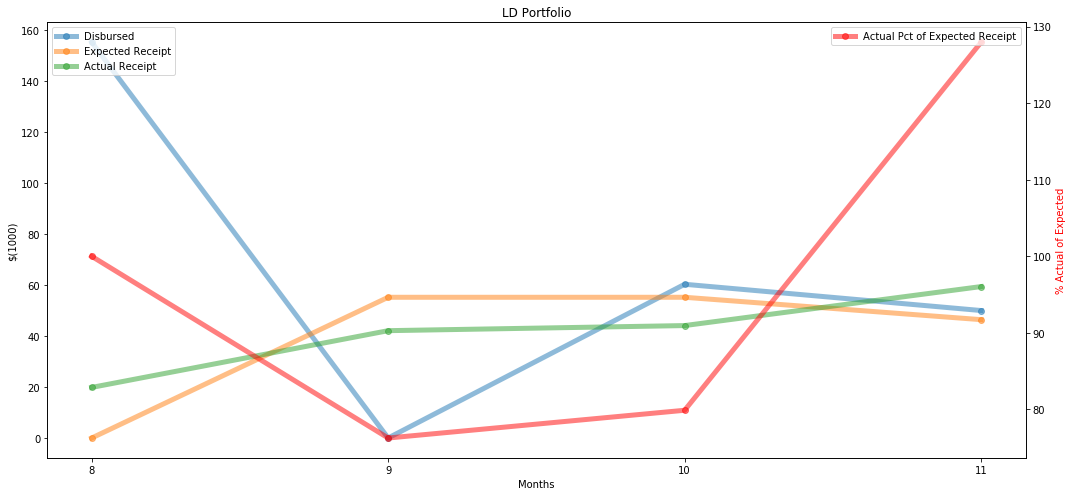

In [156]:
plot_result_twin_axis(x_vals, disb, exp, act, x_label='Months', ax1_ylabel='$(1000)', ax2_ylabel='% Actual of Expected',
                      title='LD Portfolio',  pct_act_exp=act_pct, 
                norm=1000, figsize=(15, 7), rotation=0, pct_exp=True)

In [145]:
# plot_result(x_vals, disb, exp, act, pct_act_exp=act_pct, x_label='Months', y_label=None, title='Monthly distributions of LD portfolio', 
#             norm=1000, figsize=(10, 5), rotation=0, pct_exp=True)

In [153]:
# usd plots
x_vals = np.array(usd_result['months'])
x_pos = np.arange(1, len(x_vals) + 1)
disb = np.array(usd_result['disbursed'])
exp = np.array(usd_result['expected'])
act = np.array(usd_result['actual'])
act_pct = np.array([100 * a / e if e !=0 else 100.0 for a, e in zip(act, exp)])

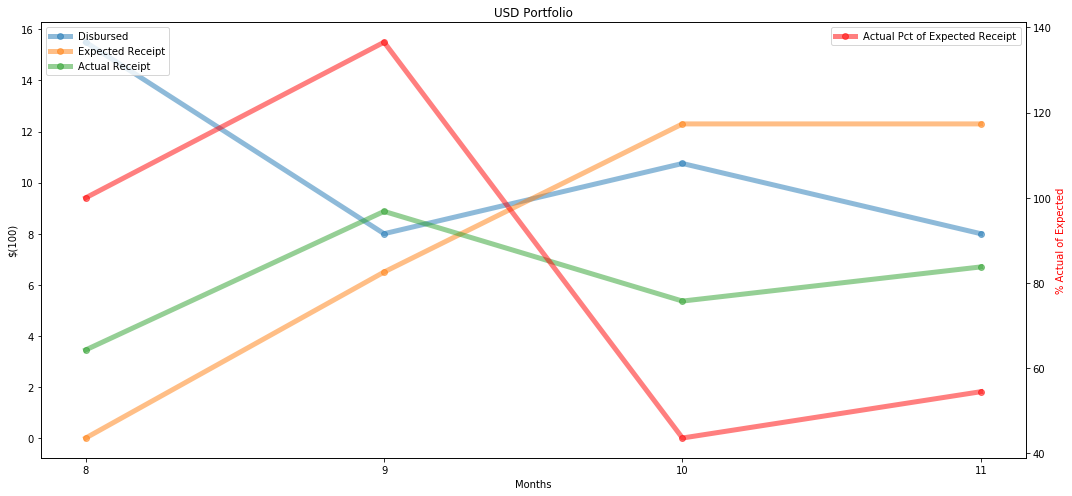

In [154]:
plot_result_twin_axis(x_vals, disb, exp, act, x_label='Months', ax1_ylabel='$(100)', ax2_ylabel='% Actual of Expected',
                      title='USD Portfolio',  pct_act_exp=act_pct, 
                norm=100, figsize=(15, 7), rotation=0, pct_exp=True)

In [148]:
# plot_result(x_vals, disb, exp, act, pct_act_exp=act_pct, x_label='Months', y_label=None, title='Monthly distributions of USD portfolio', 
#             norm=100, figsize=(10, 5), rotation=0, pct_exp=True)

In [157]:
usd_result_df = DF(usd_result)
usd_result_df.to_excel('monthly_usd.xlsx', header=True, index=False)

In [158]:
ld_result_df = DF(ld_result)
ld_result_df.to_excel('monthly_ld.xlsx', header=True, index=False)

In [70]:
act

array([ 19840.,  61940.,  44100.,  59400.])

In [71]:
mod_act

array([ 61940.,  44100.,  59400.])

In [72]:
act[0]

19840.0

In [73]:
act[0] + act[1]

81780.0

In [74]:
mod_act[0] = act[0] + act[1]

In [75]:
mod_act

array([ 81780.,  44100.,  59400.])

In [76]:
act

array([ 19840.,  81780.,  44100.,  59400.])